# Home Assignment No. 2: Part 2 (Practice)
To solve this task, you will write a lot of code to try several deep learning methods.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [pytorch](https://pytorch.org/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you may be asked to provide short discussion of the results. In this cases you have to create **MARKDOWN** cell with your comments right after the your code cell.

* For every separate (sub)problem you can get only 0 points or maximal points for this (sub)problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute `Kernel` -> `Restart Kernel and Run All Cells`, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

## Task 1. Deep ANNs. (5 points)

### Task 1.1.  Activation functions. (1 point)
Plot the following [activation functions](https://pytorch.org/docs/master/nn.html#non-linear-activation-functions) using their PyTorch realizations and their derivatives using [autograd](https://pytorch.org/docs/stable/autograd.html) functionality `grad()`:
   
1. **(1 pt.)** Plot `ReLU`, `ELU` ($\alpha = 1$), `Softplus` ($\beta = 1$) and `Sign`, `Sigmoid`, `Softsign`, `Tanh`.
Which of these functions may be, and which - definitely, are a poor choise as an activation function in a neural network? Why?

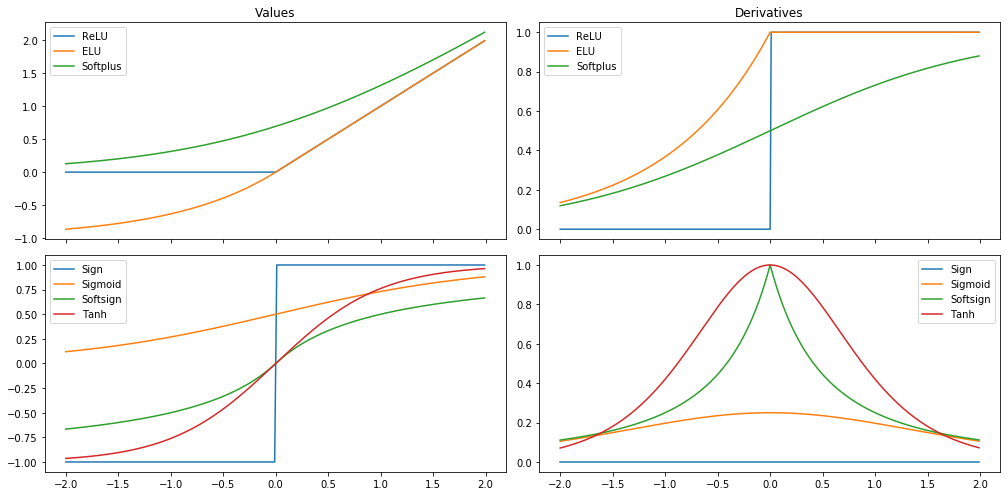

In [303]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

x = torch.arange(-2, 2, .01, requires_grad=True)
x_np = x.detach().numpy()
x.sum().backward() # to create x.grad

f, axes = plt.subplots(2, 2, sharex=True, figsize=(14, 7))
axes[0, 0].set_title('Values')
axes[0, 1].set_title('Derivatives')

for i, function_set in (0, (('ReLU', F.relu), ('ELU', F.elu), ('Softplus', F.softplus))), \
                       (1, (('Sign', torch.sign), ('Sigmoid', torch.sigmoid), ('Softsign', F.softsign), ('Tanh', torch.tanh))):
    for function_name, activation in function_set:
        ### BEGIN Solution

        gradient = torch.autograd.grad(inputs = x, outputs = activation(x), grad_outputs = torch.ones_like(x))
        
        axes[i, 0].plot(x.detach().numpy(), activation(x).detach().numpy(), label = function_name)
        axes[i, 1].plot(x.detach().numpy(), gradient[0].detach().numpy() , label = function_name)

        ### END Solution

    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

Poor choises:
- ReLU: when we will compute gradients in backpropagation, for values $<0$ we will get zero derivative, so they will not be taken into account (so the answer is maybe)
- Sign: again we encounter problems with gradient, we have zero for any value, so this function is absolutely useless in backpropagation (so the answer is definitely)

### Task 1.2. MNIST classification. (4 points)

At the **[Seminar 13](https://github.com/adasegroup/ML2020_seminars/tree/master/seminar12)** on neural networks, we designed an MLP (Multilayer perceptron) with one hidden layer using our numpy implementations of linear layer, logistic and softmax activation functions. In this task, you are to

1. **(1 pt.)** Implement the MLP modules, including the Softmax cross entropy between `logits` and `labels`.
2. **(2 pt.)** Train our numpy realization of MLP to classify the MNIST from `sklearn.datasets()`. The required accuracy on validation is `> 90%`.
3. **(1 pt.)** Compare the acccuracy of classification to your scores from `Part 1` with and without dimensionality reduction. Is this comparison fair? :) Derive the confusion matrix for all digits classes. Which digits are predicted better or worse than others?

In [1434]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [1435]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]

input_size = 8*8
classes_n = 10

**Implement the MLP with backprop.**

In [1436]:
#Here you should implement by yourself MLP class and its constituents including forward and backward propagation methods

class Linear:
    def __init__(self, input_size, output_size):
        # Trainable parameters of the layer and their gradients
        self.thetas = np.random.randn(input_size, output_size) # the weight matrix of the layer (W)
        self.thetas_grads = np.empty_like(self.thetas) # gradient w.r.t. the weight matrix of the layer
        self.bias = np.random.randn(output_size) # bias terms of the layer (b)
        self.bias_grads = np.empty_like(self.bias) # gradient w.r.t. bias terms of the linear layer

    def forward(self, x): 
        output = np.matmul(x, self.thetas) + self.bias
        self.x = x
        return output
    
    def backward(self, x, output_grad):
        """
        Calculate and return gradient of the loss w.r.t. the input of linear layer given the input x and the gradient 
        w.r.t output of linear layer. You should also calculate and update gradients of layer parameters.
        :param x: np.array, input tensor for linear layer;
        :param output_grad: np.array, grad tensor w.r.t output of linear layer;
        :return: np.array, grad w.r.t input of linear layer
        """
        
        ### BEGIN Solution
        # ... calculate grads
        input_grad = np.matmul(output_grad, self.thetas.T)
        #print('output_grad',output_grad.shape)
        #print('x',self.x.shape)
        #print('x',self.x.T.shape)
        self.thetas_grads = np.matmul(self.x.reshape(-1,1), output_grad)
        self.bias_grads = output_grad.sum(axis=0)
        ### END Solution
        return input_grad

class LogisticActivation:
    def __init__(self):
        # the layer has no parameters
        pass 
    
    def forward(self, x):
        output = 1/(1 + np.exp(-x))
        #self.logistic = output
        return output


    def backward(self, x, output_grad):
        """
        Calculate and return the gradient of the loss w.r.t. the input
        of logistic non-linearity (given input x and the gradient 
        w.r.t output of logistic non-linearity).
        
        :param x: np.array, input tensor for logistic non-linearity;
        :param output_grad: np.array, grad tensor w.r.t output of logistic non-linearity;
        :return: np.array, grad w.r.t input of logistic non-linearity
        
        """
        
        input_grad = output_grad * (self.forward(x) * (1 - self.forward(x)))
        return input_grad


class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        return self.linear2.forward(self.activation1.forward(self.linear1.forward(x)))

    def backward(self, x, output_grad):
        """
        Calculate and return the gradient of the loss w.r.t. the input of MLP given the input and the gradient 
        w.r.t output of MLP. You should also update gradients of paramerters of MLP layers.
        Hint - you should chain backward operations of modules you have already implemented. You may also
        need to calculate intermediate forward results.
        
        :param x: np.array, input tensor for MLP;
        :param output_grad: np.array, grad tensor w.r.t output of MLP;
        :return: np.array, grad w.r.t input of MLP
        """
 
        ### BEGIN Solution
        print(x.shape)
        second_out_grad = self.linear2.backward(x,output_grad)
        output_grad = self.linear1.backward(x, self.activation1.backward(x, second_out_grad))
        
        return output_grad
        ### END Solution

In [1437]:
### BEGIN Solution
def softmax(x):
    return np.exp(x) / (np.exp(x).sum(axis=-1, keepdims=True))

def softmax_crossentropy_with_logits(logits, reference_answers):
    return np.log(np.sum(np.exp(logits), axis=-1)) - logits

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    return (softmax(logits) - reference_answers) / logits.shape[0]
### END Solution
# https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9 - inspiration

In [1439]:
np.random.seed(42)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 100
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-2

for epoch in range(epochs_n):
        
    for sample_i in range(train_size):
        x = x_train[sample_i].reshape((1, -1))
        target = np.array([y_train[sample_i]])

        ### BEGIN Solution
        # ... zero the gradients of the model
        # ... perform forward pass and compute the loss
        
        mlp.linear1.thetas_grads = np.empty_like(mlp.linear1.thetas_grads.shape)
        mlp.linear2.thetas_grads = np.empty_like(mlp.linear1.thetas_grads.shape)
        mlp.linear1.bias_grads =  np.empty_like(mlp.linear1.thetas_grads.shape)
        mlp.linear2.bias_grads = np.empty_like(mlp.linear1.thetas_grads.shape)
        
        #mlp.linear1.thetas_grads.zero_()
        #mlp.linear2.thetas_grads.zero_()
        #mlp.linear1.bias_grads.zero_()
        #mlp.linear2.bias_grads.zero_()
        
        prediction = mlp.forward(x) 
        
        #learning_curve[epoch] += softmax_crossentropy_with_logits(prediction, target)
        # ... compute the gradients w.r.t. the input of softmax layer
        grad_softmax = grad_softmax_crossentropy_with_logits(prediction, target)
        # ... perform backward pass
        
        mlp.backward(prediction, grad_softmax)
        
        # ... and update the weights with weight -= grad * learning_rate
        print(mlp.linear1.thetas.shape)
        print(mlp.linear1.thetas_grads.shape)
        mlp.linear1.thetas -= mlp.linear1.thetas_grads * learning_rate
        mlp.linear2.thetas -= mlp.linear2.thetas_grads * learning_rate
        mlp.linear1.bias -= mlp.linear1.bias_grads * learning_rate
        mlp.linear2.bias -= mlp.linear2.bias_grads * learning_rate
        # >>> your solution here <<<
        
    prediction = mlp.forward(x_test)
    
    acc = accuracy_score(np.argmax(prediction, axis = 1), y_test) # github helped to use acc_score properly
    
    if epoch % 10 == 0:
        print('Starting epoch {}'.format(epoch),', Accuracy on test: ', acc)
        print()
        
     
    #test_curve[epoch] = softmax_crossentropy_with_logits(prediction, y_test)
    #learning_curve[epoch] = learning_curve[epoch] / train_size
'''  
plt.figure(figsize = (14, 7))
plt.plot(learning_curve, label='train')
plt.plot(test_curve, label='test')
plt.legend(loc = 'best', fontsize = 14)
plt.title('Softmax crossentropy loss with logits, training on MNIST', fontsize = 14)
plt.show()
'''  
    ### END Solution

Starting epoch 0 , Accuracy on test:  0.06666666666666667

Starting epoch 10 , Accuracy on test:  0.6488888888888888

Starting epoch 20 , Accuracy on test:  0.8066666666666666

Starting epoch 30 , Accuracy on test:  0.8711111111111111

Starting epoch 40 , Accuracy on test:  0.8888888888888888

Starting epoch 50 , Accuracy on test:  0.9044444444444445

Starting epoch 60 , Accuracy on test:  0.9244444444444444

Starting epoch 70 , Accuracy on test:  0.9311111111111111

Starting epoch 80 , Accuracy on test:  0.9311111111111111

Starting epoch 90 , Accuracy on test:  0.9333333333333333



In [1440]:
# confusion matrix
pd.DataFrame(confusion_matrix(targets, mlp.forward(digits).argmax(axis=1)))

,0,1,2,3,4,5,6,7,8,9
0,176,0,0,0,1,1,0,0,0,0
1,0,166,2,0,0,0,2,0,3,9
2,0,3,171,2,0,0,0,1,0,0
3,0,0,0,178,0,1,0,2,1,1
4,0,0,0,0,175,0,0,4,1,1
5,0,0,0,0,1,174,1,0,0,6
6,1,2,0,0,1,0,177,0,0,0
7,0,0,0,0,0,0,0,177,1,1
8,0,16,2,2,0,4,1,3,144,2
9,0,2,0,8,2,3,0,4,3,158


## Task 2. Autoencoders. (7 points)

### Task 2.1.  Autoencoder on the tabular data. (3 points)


We will build a latent representation for tabular data with simple Autoencoder (AE). We are going to work with the cancer dataset from scikit-learn package. You are to follow the instructions `1.0 - 1.6`.  

1. **(1 pt.)** Implement AE modules;
2. **(2 pt.)** Train AE to get latent representation of the cancer dataset from `sklearn.datasets()`. Use `MSE` loss and get < $0.28$ on validation, with AE "bottleneck" = $2$;
3. **(1 pt.)** Plot the latent representation of whole dataset in 2D, use colors to show object of differneet classes;

In [608]:
# imports
import sklearn.datasets as sk_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.utils.data as torch_data

#### 1.0 Featch the data. Scale it and split on train and test.

In [609]:
cancer_dset = sk_data.load_breast_cancer()

X = StandardScaler().fit_transform(cancer_dset['data'])

print('Features: ', list(cancer_dset['feature_names']))
print('\nShape:', X.shape)

X_train, X_val, y_train, y_val = train_test_split(X, cancer_dset['target'], test_size=0.2, random_state=42)
print('\nTrain size: ', len(X_train))
print('Validation size: ', len(X_val))

Features:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

Shape: (569, 30)

Train size:  455
Validation size:  114


#### 1.1 Let us firtly create the dataset, which we'll be able to use with pytorch dataloader. 
Implement `__len__` and `__getitem__` methods.

In [610]:
class CancerData(torch_data.Dataset):
    def __init__(self, X, y):
        super(CancerData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [611]:
train_dset = CancerData(X_train, y_train) 
val_dset = CancerData(X_val, y_val) 

print(train_dset[5])

(tensor([ 0.1172,  1.9199,  0.1961,  0.0111,  1.2482,  1.0453,  0.9429,  0.6376,
         1.7940,  1.1302, -0.1269, -0.3336,  0.0064, -0.1713, -0.4780,  0.9458,
         0.5145, -0.1454, -0.2388,  0.6321,  0.2466,  1.8650,  0.5016,  0.1101,
         1.5532,  2.5664,  2.0649,  0.8617,  2.1310,  2.7793]), tensor(0.))


#### 1.2 Now, we'll make a base class for our autoencoder. 
AE takes as input encoder and decoder (it will be two neural networks). Your task is to implement the forward pass.

In [612]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### 1.3 It is high time to create encoder an decoder neural networks!
Make hidden size of the network to be equal to `2`.

**Hint.** You can use `nn.Sequential` to create your own archtectures.

In [1157]:
input_size = 30
hidden_half = int(input_size/2)
hidden_size = 2
output_size = 2
batch_train  = 20
batch_test = 200
lr = 0.08
gamma = 0.75

encoder = lambda hid : nn.Sequential( 
                                    nn.BatchNorm1d(input_size),
                                    
                                    nn.Linear(input_size, input_size),
                                    nn.ReLU(), 
                                    #nn.BatchNorm1d(hid),
                                    #nn.Dropout(),
                                    nn.Linear(input_size, hidden_half),
                                    nn.ReLU(),
                                    nn.Linear(hidden_half, hid)
                                    #nn.Dropout(),
                                    #nn.Tanh(),
                                    )  

decoder = lambda hid : nn.Sequential(
                                    #nn.Tanh(),
                                    nn.Linear(hid, hidden_half),
                                    #nn.Dropout(),
                                    nn.ReLU(),
                                    nn.Linear(hidden_half, input_size),
                                    #nn.Dropout(),
                                    nn.ReLU(),
                                    nn.Linear(input_size, input_size)
                                    )

In [1158]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = MyFirstAE(encoder(2), decoder(2)) 
criterion = nn.MSELoss()

net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(100, ), gamma = gamma)


train_loader = torch_data.DataLoader(train_dset, batch_size = batch_train, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size = batch_test, shuffle=False) 

#### 1.4 Implement the missing parts of the `train` function

In [1114]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X, _ in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            
            X = X.to(device)
            optimizer.zero_grad()
            
            loss = criterion(X, net(X))
            
            loss.backward()
            optimizer.step()
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, _ in val_loader:
            # Compute the validation loss
            X = X.to(device)
            
            val_loss = criterion(X, net(X))
        
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))

#### 1.5 Train your AE on breast cancer dataset. 
Your goal is to get validation error <0.3.

Some features that may help you to improve the performance:
* `Dropout`
* `Batchnorm`
* lr scheduler
* Batch size increase/decrease

In [1144]:
# for `MSE` loss get < 0.28 on validation, with AE "bottleneck" = 2
train(400, net, criterion, optimizer, train_loader, val_loader, scheduler) 
# I achieved < 0.3 (tried different activation function and changed every parameter I could).

Epoch 20/400 || Loss:  Train 0.3249 | Validation 0.3096
Epoch 40/400 || Loss:  Train 0.2880 | Validation 0.2975
Epoch 60/400 || Loss:  Train 0.3425 | Validation 0.3028
Epoch 80/400 || Loss:  Train 0.3736 | Validation 0.3068
Epoch 100/400 || Loss:  Train 0.4613 | Validation 0.3089
Epoch 120/400 || Loss:  Train 0.3446 | Validation 0.3101
Epoch 140/400 || Loss:  Train 0.2856 | Validation 0.3077
Epoch 160/400 || Loss:  Train 0.4606 | Validation 0.3064
Epoch 180/400 || Loss:  Train 0.3565 | Validation 0.3033
Epoch 200/400 || Loss:  Train 0.3298 | Validation 0.3058
Epoch 220/400 || Loss:  Train 0.2288 | Validation 0.2953
Epoch 240/400 || Loss:  Train 0.4093 | Validation 0.3090
Epoch 260/400 || Loss:  Train 0.3569 | Validation 0.2969
Epoch 280/400 || Loss:  Train 0.4354 | Validation 0.3030
Epoch 300/400 || Loss:  Train 0.2739 | Validation 0.2974
Epoch 320/400 || Loss:  Train 0.3247 | Validation 0.2951
Epoch 340/400 || Loss:  Train 0.2301 | Validation 0.2990
Epoch 360/400 || Loss:  Train 0.330

#### 1.6 Let's take a look at the latent space. 
Encode the whole dataset, using your AE, plot it in 2D and use colors to show object of differneet classes

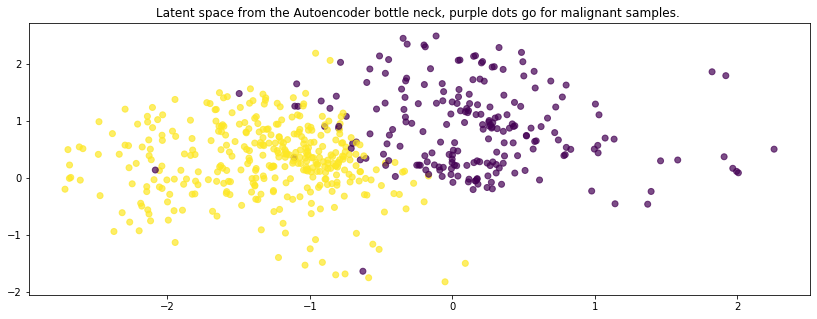

In [1133]:
 ### BEGIN Solution
plt.figure(figsize=(14, 5))
net.eval()

a = torch.tensor(X, dtype = torch.float32)
#b = torch.tensor(y, dtype = torch.float32)

enc = net.encoder(a.to(device)).detach().numpy()

plt.scatter(enc[:,0], enc[:,1], c=cancer_dset['target'], alpha=0.7);
plt.title('Latent space from the Autoencoder bottle neck, purple dots go for malignant samples. ');
 ### END Solution

### Task 2.2.  Autoencoder on kMNIST. (4 points)


We will build a latent representation for `kMRIST` dataset by using our AE. We will work with the data from `Part 1`.

1. **(2 pt.)** Train AE to get latent representation of the `kMNIST` dataset from `sklearn.datasets()`. Follow the instructions `2.0 - 2.4`. Use `MSE` loss and obtain < $0.035$ on validation, with AE "bottleneck"  $\leq 40$;
2. **(1 pt.)** Plot 10 images and their reconstructions. Plot the latent representation of the whole dataset in 3D, compare visually to your manifold from `Part 1` and upload (pictures) screenshots to this notebook.
3. **(1 pt.)** Get the classification accuracy for the latent features. Use the `KNN` classifier with any hyperparameters you like. Write a couple of sentences about the differences of `manifold learning` and ` AE` results. 
3. **(BONUS 3 pt.)** Sampling from latent representation.

In [1367]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('data/kmnist/kmnist-train-imgs.npz')
x_test = load('data/kmnist/kmnist-test-imgs.npz')
y_train = load('data/kmnist/kmnist-train-labels.npz')
y_test = load('data/kmnist/kmnist-test-labels.npz')

# Reshape the data and scale

scaler = StandardScaler().fit(x_train.reshape(x_train.shape[0], -1))
#scaler_test = StandardScaler()#.fit(x_test.reshape(x_test.shape[0], -1))

x_train_sc = scaler.transform(x_train.reshape(x_train.shape[0], -1)) 
x_test_sc = scaler.transform(x_test.reshape(x_test.shape[0], -1))

print(x_train_sc.shape) # for linear testing

x_train_sc = x_train_sc.reshape(x_train.shape[0], 1, 28, 28)
x_test_sc = x_test_sc.reshape(x_test.shape[0], 1, 28, 28)

print(x_train_sc.shape) # for convolutional nn

(60000, 784)
(60000, 1, 28, 28)


In [1368]:
'''
scaler_train_ = StandardScaler().fit(y_train.reshape(y_train.shape[0], -1))
#scaler_test_ = StandardScaler().fit(y_test.reshape(y_test.shape[0], -1))

y_train_sc = scaler_train_.transform(y_train.reshape(y_train.shape[0], -1))
y_test_sc = scaler_train_.transform(y_test.reshape(y_test.shape[0], -1))
'''

'\nscaler_train_ = StandardScaler().fit(y_train.reshape(y_train.shape[0], -1))\n#scaler_test_ = StandardScaler().fit(y_test.reshape(y_test.shape[0], -1))\n\ny_train_sc = scaler_train_.transform(y_train.reshape(y_train.shape[0], -1))\ny_test_sc = scaler_train_.transform(y_test.reshape(y_test.shape[0], -1))\n'

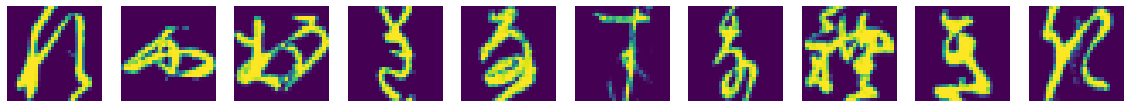

In [1369]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(x_train[i].reshape(28,28));
    ax[i].axis('off') 

In [1370]:
class kMNISTData(torch_data.Dataset): # analogically to 1-st
    def __init__(self, X, y):
        super(kMNISTData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [1371]:
train_kmnist = kMNISTData(x_train_sc, y_train) 
test_kmnist = kMNISTData(x_test_sc, y_test) 

#### 2.0 Create encoder and decoder network for kMNIST. 
You can either use convolutions or flatten the images and use linear layers. You can choose hidden size (not larger than 40) and any architecture you like.

In [1380]:
input_size = 784
output_size = 10
hidden_half = int(input_size/2)
'''
encoder = lambda hid : nn.Sequential( 
                                    nn.BatchNorm1d(input_size),
                                    
                                    nn.Linear(input_size, input_size),
                                    nn.ReLU(), 
                                    #nn.BatchNorm1d(hid),
                                    #nn.Dropout(),
                                    nn.Linear(input_size, hidden_half),
                                    nn.ReLU(),
                                    nn.Linear(hidden_half, output_size)
                                    #nn.Dropout(),
                                    #nn.Tanh(),
                                    )  

decoder = lambda hid : nn.Sequential(
                                    #nn.Tanh(),
                                    nn.Linear(output_size, hidden_half),
                                    #nn.Dropout(),
                                    nn.ReLU(),
                                    nn.Linear(hidden_half, input_size),
                                    #nn.Dropout(),
                                    nn.ReLU(),
                                    nn.Linear(input_size, input_size)
                                    )

'''

In [1444]:
encoder = lambda hid : nn.Sequential(
                                    nn.Conv2d(1, int(hid/5), 3),
                                    nn.BatchNorm2d(int(hid/5)),
                                    nn.Conv2d(int(hid/5), int(hid), 19),
                                    nn.BatchNorm2d(int(hid))
                                    )  

decoder = lambda hid : nn.Sequential(
                                    nn.ConvTranspose2d(int(hid), int(hid/5), 19),
                                    nn.BatchNorm2d(int(hid/5)),
                                    nn.ConvTranspose2d(int(hid/5), 1, 3),
                                    nn.BatchNorm2d(1)
                                    )

In [ ]:
epochs = 10
train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler)
# It seems that I normilized basically all, but score still too high (so I do not get the mistake). Maybe needed more epochs...

Epoch 1/10 || Loss:  Train 0.2093 | Validation 0.2415
Epoch 2/10 || Loss:  Train 0.2055 | Validation 0.2405
Epoch 3/10 || Loss:  Train 0.2324 | Validation 0.2405
Epoch 4/10 || Loss:  Train 0.2229 | Validation 0.2395
Epoch 5/10 || Loss:  Train 0.2448 | Validation 0.2392
Epoch 6/10 || Loss:  Train 0.2386 | Validation 0.2397


#### 2.1 Train AE on the kMNIST. 
Your goal is to obtain MSE on the test set < $0.035$ on `MyFirstAE(encoder(40), decoder(40))`.

In [1381]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = MyFirstAE(encoder(40), decoder(40)) 
criterion = nn.MSELoss()
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr = 0.2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(100, ), gamma=.75)

train_loader = torch_data.DataLoader(train_kmnist, batch_size=200, shuffle=True) 
val_loader = torch_data.DataLoader(test_kmnist, batch_size=200, shuffle=False) 

In [1407]:
epochs = 10
train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler)
# It seems that I normilized basically all, but score still too high (so I do not get the mistake). Maybe needed more epochs...

Epoch 1/10 || Loss:  Train 0.2238 | Validation 0.2432
Epoch 2/10 || Loss:  Train 0.2265 | Validation 0.2436
Epoch 3/10 || Loss:  Train 0.2050 | Validation 0.2421
Epoch 4/10 || Loss:  Train 0.2216 | Validation 0.2417
Epoch 5/10 || Loss:  Train 0.2370 | Validation 0.2410
Epoch 6/10 || Loss:  Train 0.2224 | Validation 0.2404
Epoch 7/10 || Loss:  Train 0.2382 | Validation 0.2414
Epoch 8/10 || Loss:  Train 0.2300 | Validation 0.2406
Epoch 9/10 || Loss:  Train 0.2242 | Validation 0.2399
Epoch 10/10 || Loss:  Train 0.2315 | Validation 0.2407


#### 2.2 Plot any 10 images and their reconstructions.

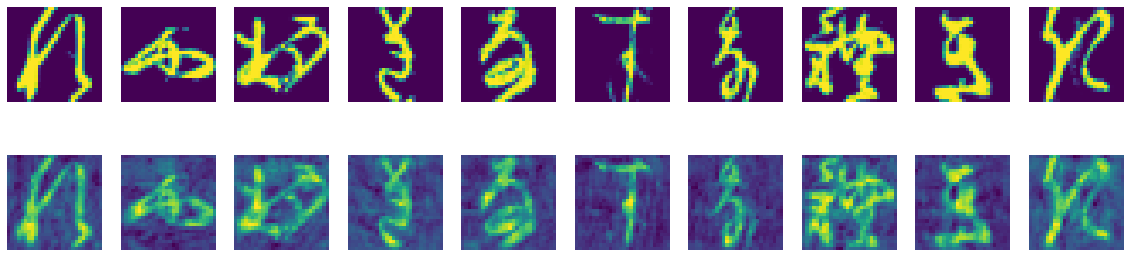

In [1408]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
    #im = train_kmnist[i][0]
    im = x_train[i]
    rec = net(torch.tensor(x_train[i].reshape(1, 1, 28, 28), dtype=torch.float32).to(device))
    
    ax[0, i].imshow(im.reshape(28,28));
    ax[1, i].imshow(rec.detach().numpy().reshape(28,28));
    ax[0, i].axis('off')
    ax[1, i].axis('off')

#### 2.3 Plot the latent representation of whole dataset in 3D, compare visually to your manifold from `Part 1` and upload (pictures) screenshoots to this notebook.

In [1409]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import colorlover as cl

init_notebook_mode(connected=True)

from sklearn.decomposition import PCA

import pandas as pd

In [1430]:
### BEGIN Solution
# we can get nessesary picture after dimensionality reduction
a = net.encoder(torch.tensor(x_test_sc, dtype = torch.float32)).detach().numpy()
PCA_N = PCA(n_components = 5)
S_pca_ = PCA_N.fit_transform(a.reshape(x_test_sc.shape[0], 8*64))

digits_3d = pd.DataFrame({
    'x': S_pca_[:, 0], 
    'y': S_pca_[:, 1], 
    'z': S_pca_[:, 2],
    'label': y_test
})

colors = cl.scales['10']['qual']['Paired']
data = []

for i in range(10):
    x = digits_3d[digits_3d['label'].astype('int') == i]['x']
    y = digits_3d[digits_3d['label'].astype('int') == i]['y']
    z = digits_3d[digits_3d['label'].astype('int') == i]['z']
    
    color = colors[i]
    
    trace = {
        'name': str(i),
        'x': x,
        'y': y,
        'z': z,
        'type': 'scatter3d',
        'mode': 'markers',
        'marker': {
            'size': 5,
            'color': color 
        }
    }
    data.append(trace)

layout = go.Layout(
    title='MNIST visualization PCA',
    width=900,
    height=600
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link = False)

### END Solution

Image from 1st part of homework:

![title](mnist_1.png)

Image from 1st part of homework:

![title](mnist_2.png)

#### 2.4 Get the classification accuracy for the latest features. Use the `KNN` classifier with any hyperparameters you'll choose. Write a couple of sentences comparing the results of `manifold learning` and ` AE`. 

In [1419]:
### BEGIN Solution
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier(n_jobs = -1, n_neighbors = 3)
#PCA_N = PCA(n_components = 50, random_state = seed)

#X_train = PCA_N.fit_transform(x_train)
clf.fit(x_train[:,0], y_train)
prediction = clf.predict(x_test[:,0])
print('Accuracy :', accuracy_score(prediction, y_test))

### END Solution

# Because of poor scoring accuracy is corresponding. But with good learning AE will outperform manifold learning.

Accuracy : 0.1653


### BONUS: Sampling from latent space. (3 points)

Imagine, that you want to generate images, using you AE. To do that, you need to sample from the latent space and then decode the result. Of course, we do not know the exact distribution of the latent space. Therefore, let us assume that latent space distribution is Gaussian:

* Encode all the training images into the latent space
* Calculate mean and covariance matrix ($\mu$ and $\Sigma$)
* Sample  $z$ from the $\mathcal{N}(\mu, \Sigma)$
* Decode $z$ from the previous step to obtain an image

Using the procedure described above, sample 10 images and plot them (they should be similar to those of the initial dataset)

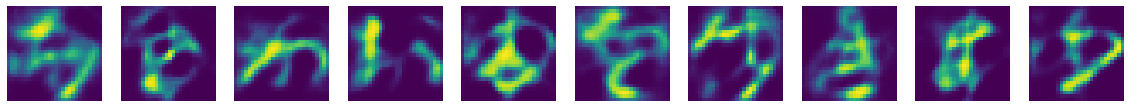

In [111]:
### BEGIN Solution

# >>> your solution here <<<

### END Solution

**Yeah, so you can get more than `100%` for the homework, good luck!**